# Forward-bias PIN phase shifter with thermal analysis

A Mach-Zehnder modulator is an optical device used to control the intensity of a light beam. It works by splitting a laser beam into two paths and then recombining them. By changing the phase of light in one path relative to the other, we can control whether the waves interfere constructively (bright output) or destructively (dark output). This allows for high-speed modulation, making such modulators ideal for encoding data onto light signals in fiber-optic communications. This notebook focuses on the forward-bias PIN phase shifter, which is the active component of the modulator.

The "PIN" structure consists of P-type, Intrinsic, and N-type semiconductor regions. Applying a forward bias voltage to this junction injects charge carriers into the intrinsic region. This changes the material's refractive index via the plasma dispersion effect, altering the light's phase in that path and thus controlling the overall modulator's interference at the output.

The electrical current flowing through the device during the operation of the PIN diode generates heat, which is most significant during the 'ON' state of the modulation cycle. This heat can significantly affect the performance of the phase shifter. In particular, the carrier mobility (electrons and holes) in the semiconductor is temperature-dependent, which ultimately affects the speed and efficiency of the device.

By including the thermal effects in the simulation, we can accurately predict the phase shifter's performance under realistic operating conditions and optimize its design for thermal stability.

<center><img src="./img/pin_phase_shifter.png" width=640 /></center>

## Scope
This notebook demonstrates how to use our multiphysics simulation capabilities to assess the thermal and electric characteristics of a forward-bias PIN phase shifter, which is essential for the operation of devices like the Mach-Zehnder modulator. This notebook will guide the user through setting up the geometry, defining the materials and their physical models, running the simulation, and analyzing the results. For this notebook we use different models for the effective Density of States (DOS) model with temperature dependence.

In order to appreciate the difference in the simulation, we will perform three simulations to assess the impact of temperature on the device's performance:

- **Non-isothermal simulation with temperature-dependent DOS**: This is the most comprehensive simulation, including both heat transport and a temperature-dependent model for the DOS.
- **Non-isothermal simulation with constant DOS**: This simulation includes heat transport but assumes a constant DOS, allowing us to isolate the effect of the temperature-dependent DOS model.
- **Isothermal simulation with constant DOS**: This is a baseline simulation that neglects thermal effects and assumes a constant DOS.

For ease of reference, these models will be referred to as:

1. **Effective DOS**
2. **Constant DOS**
3. **Isothermal**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import tidy3d as td
import tidy3d.web as web

## Device Geometry

We begin by defining the key geometric parameters of the Mach-Zehnder modulator in micrometers (µm). This includes the pad, rib, silicon-on-insulator (SOI) box, cathode, and anode.

In [2]:
z_size = 4  # µm

# pad size
pad_center = (0, -0.045, 0)
x_pad_w = 5
y_pad_h = 0.09
pad_size = (x_pad_w, y_pad_h, z_size)

# rib size
rib_center = (0, 0.11, 0)
x_rib_w = 0.5
y_rib_h = 0.22
rib_size = (x_rib_w, y_rib_h, z_size)

# enclosing box + sox
soxbox_center = (0, -0.545, 0)
y_soxbox_h = 3.09
x_box_w = 5
soxbox_size = (x_box_w, y_soxbox_h, z_size)

# cathode
cathode_center = (-2.25, 0.25, 0)
y_cathode_h = 0.5
x_cathode_w = 0.5
cathode_size = (x_cathode_w, y_cathode_h, z_size)

# anode
anode_center = (2.25, 0.25, 0)
y_cathode_h = 0.5
x_anode_w = 0.5
anode_size = (x_anode_w, y_cathode_h, z_size)

## Doping and materials
In this section, we define the doping profiles and the physical properties of the materials used in the simulation.

In the cell below, we define the following doping profiles:
- `Constant Doping`: A constant acceptor doping concentration is defined for the p-type epitaxial (pepi) layer.
- `Gaussian Doping`: Gaussian doping profiles are used for the n+, p+, n-well, and p-well regions. These profiles are defined with specific centers, sizes, concentrations, reference concentrations, and junction widths. The `source` parameter sets the origin plane of the doping, ensuring the concentration is constant along that plane and decays along all other axes.

In [3]:
# pepi
conc_cst = 1e15
acceptor_cst_doping = td.ConstantDoping(center=(0, -1, 0), size=(5.4, 4, 4), concentration=conc_cst)

junction_width_01 = 1e-1
junction_width_02 = 2e-1

# nplus
conc_nplus = 2e18
refconc_nplus = 1e8
donor_nplus_center = (-1.5, 0, 0)
donor_nplus_size = (2.0, 2, z_size)
donor_nplus_doping = td.GaussianDoping(
    center=donor_nplus_center,
    size=donor_nplus_size,
    concentration=conc_nplus,
    ref_con=refconc_nplus,
    width=junction_width_01,
    source="ymax",
)

# pplus
conc_pplus = 2e18
refconc_pplus = 1e8
acceptor_pplus_center = (1.5, 0, 0)
acceptor_pplus_size = (2.0, 2, z_size)
acceptor_pplus_doping = td.GaussianDoping(
    center=acceptor_pplus_center,
    size=acceptor_pplus_size,
    concentration=conc_pplus,
    ref_con=refconc_pplus,
    width=junction_width_01,
    source="ymax",
)

# nwell
conc_nwell = 1e20
refconc_nplus = 1e8
donor_nwell_center = (-1.8, -0.5, 0)
donor_nwell_size = (1.4, 1, z_size)
donor_nwell_doping = td.GaussianDoping(
    center=donor_nwell_center,
    size=donor_nwell_size,
    concentration=conc_nwell,
    ref_con=refconc_nplus,
    width=junction_width_02,
    source="ymax",
)

# pwell
conc_pwell = 1e20
refconc_pwell = 1e8
acceptor_pwell_center = (1.8, -0.5, 0)
acceptor_pwell_size = (1.4, 1.0, z_size)
acceptor_pwell_doping = td.GaussianDoping(
    center=acceptor_pwell_center,
    size=acceptor_pwell_size,
    concentration=conc_pwell,
    ref_con=refconc_pwell,
    width=junction_width_02,
    source="ymax",
)

### Material Properties for Simulation

To accurately model the device's behavior, we define `MultiPhysicsMedium` objects that integrate both the electrical (`charge`) and thermal (`heat`) properties of each constituent material.

- **Doped Silicon**: This represents the active semiconductor material. It combines the complex charge dynamics defined in the `si_charge` object with the thermal conductivity and heat capacity of silicon. This medium is the main focus of the electro-thermal simulation.
- **Silicon Dioxide**: This material serves as the insulator. Its definition includes its dielectric properties, specified using the `ChargeInsulatorMedium` class, and its thermal characteristics, described by the `SolidMedium` class.
- **Aluminum**: This defines the metal contacts. Electrically, it is treated as a charge conductor using the `ChargeConductorMedium` class, while its thermal properties are described by the `SolidMedium` class.
- **Air and Contact Media**: These represent the surrounding environment and thermal contacts. Their properties are described using the `FluidMedium` class.

The **Aluminum**, **Air**, and **Contact** media are currently used to impose boundary conditions but are excluded from the core electro-thermal simulation.


#### Mobility models
To accurately model the semiconductor behavior, we employ several well-established physical models:

- **Caughey-Thomas Mobility**: This model is used to describe the carrier mobility as a function of doping concentration and temperature for both electrons (`mobility_n`) and holes (`mobility_p`).
- **Fossum Carrier Lifetime**: The `FossumCarrierLifetime` model is used to define the carrier lifetime for electrons (`fossum_n`) and holes (`fossum_p`) which is dependent on the doping concentration.
- **Slotboom Bandgap Narrowing**: This model accounts for the reduction in the bandgap energy at high doping concentrations.
- **Isotropic Effective DOS**: `IsotropicEffectiveDOS`, is used to model the effective DOS for the conduction band ($N_c$) and valence band ($N_v$) based on the effective mass of the carriers. This is an alternative to using a constant value `ConstantEffectiveDOS`.
- **Varshni Energy Bandgap**: The Varshni Energy Bandgap model is used to describe the temperature dependence of the bandgap energy ($E_g$).

In [4]:
mobility_n = td.CaugheyThomasMobility(
    mu_min=52.2,
    mu=1471.0,
    ref_N=9.68e16,
    exp_N=0.68,
    exp_1=-0.57,
    exp_2=-2.33,
    exp_3=2.4,
    exp_4=-0.146,
)
mobility_p = td.CaugheyThomasMobility(
    mu_min=44.9,
    mu=470.5,
    ref_N=2.23e17,
    exp_N=0.719,
    exp_1=-0.57,
    exp_2=-2.23,
    exp_3=2.4,
    exp_4=-0.146,
)

alpha = 1
beta = 0
gamma = 1
sigma = 1
tau_n = 1e-7
tau_p = 2e-7
fossum_n = td.FossumCarrierLifetime(
    N0=7.1e15, A=alpha, B=beta, C=gamma, tau_300=tau_n, alpha=sigma, alpha_T=0
)
fossum_p = td.FossumCarrierLifetime(
    N0=7.1e15, A=alpha, B=beta, C=gamma, tau_300=tau_p, alpha=sigma, alpha_T=0
)

ni = 1
narrowing = td.SlotboomBandGapNarrowing(c2=0.5, n2=1e17, v1=0.0045 * 2, min_N=ni)

# Temperature dependent Eff. DOS
N_c_isotropic = td.IsotropicEffectiveDOS(m_eff=0.8)
N_v_isotropic = td.IsotropicEffectiveDOS(m_eff=1.3)
Eg_Varshni = td.VarshniEnergyBandGap(eg_0=1.16, alpha=7.02e-4, beta=1108)

# Temperature independent
N_c_cst = td.ConstantEffectiveDOS(N=N_c_isotropic.calc_eff_dos(T=300))
N_v_cst = td.ConstantEffectiveDOS(N=N_v_isotropic.calc_eff_dos(T=300))
Eg_cst = td.ConstantEnergyBandGap(eg=1.12)

si_charge = td.SemiconductorMedium(
    permittivity=11.7,
    N_c=N_c_isotropic,
    N_v=N_v_isotropic,
    E_g=Eg_Varshni,
    N_d=[donor_nplus_doping, donor_nwell_doping],
    N_a=[acceptor_cst_doping, acceptor_pplus_doping, acceptor_pwell_doping],
    mobility_n=mobility_n,
    mobility_p=mobility_p,
    R=[
        td.ShockleyReedHallRecombination(tau_n=fossum_n, tau_p=fossum_p),
        td.RadiativeRecombination(r_const=1.6e-14),
        td.AugerRecombination(c_n=2.8e-31, c_p=9.9e-32),
    ],
    delta_E_g=narrowing,
)

## -- MATERIALS
si_capacity = 711
sio2_capacity = 709
al_capacity = 902

si_conductivity = 148 * 1e-6  # W/(µm*K)
sio2_conductivity = 1.38 * 1e-6  # W/(µm*K)
al_conductivity = 236 * 1e-6  # W/(µm*K)

Si_doping = td.MultiPhysicsMedium(
    charge=si_charge,
    heat=td.SolidMedium(conductivity=si_conductivity, capacity=si_capacity),
    name="Si_doping",
)

# define semiconductor materials
SiO2 = td.MultiPhysicsMedium(
    charge=td.ChargeInsulatorMedium(permittivity=3.9),
    heat=td.SolidMedium(conductivity=sio2_conductivity, capacity=sio2_capacity),
    name="SiO2",
)

# define semiconductor materials
Al = td.MultiPhysicsMedium(
    charge=td.ChargeConductorMedium(conductivity=3.5e7 * 1e-6),
    heat=td.SolidMedium(conductivity=al_conductivity, capacity=al_capacity),
    name="Al",
)

air = td.MultiPhysicsMedium(heat=td.FluidMedium(), name="air")
contact_medium_bottom = td.MultiPhysicsMedium(heat=td.FluidMedium(), name="contact_medium_bottom")

## Geometries and Scene
The geometries defined earlier are used to create Structure objects. Each structure is assigned a medium that defines its physical properties. The collection of all these structures is then used to create a `Scene` instance, which represents the complete simulation domain. The scene is plotted to visualize the geometry and the doping profile.

In [5]:
## -- GEOMETRIES
pad_structure = td.Structure(
    geometry=td.Box(center=pad_center, size=pad_size),
    medium=Si_doping,
    name="pad",
)
rib_structure = td.Structure(
    geometry=td.Box(center=rib_center, size=rib_size),
    medium=Si_doping,
    name="rib",
)

soxbox_structure = td.Structure(
    geometry=td.Box(center=soxbox_center, size=soxbox_size),
    medium=SiO2,
    name="soxbox",
)

cathode_structure = td.Structure(
    geometry=td.Box(center=cathode_center, size=cathode_size),
    medium=Al,
    name="cathode",
)

anode_structure = td.Structure(
    geometry=td.Box(center=anode_center, size=anode_size),
    medium=Al,
    name="anode",
)

cb_thick = 0.5
contact_bottom = td.Structure(
    geometry=td.Box(center=(0, -2 - y_pad_h - cb_thick / 2, 0), size=(x_pad_w, cb_thick, 4)),
    medium=contact_medium_bottom,
    name="contact_bottom",
)


def createStructure(pad, rib):
    structures = [
        contact_bottom,
        soxbox_structure,
        cathode_structure,
        anode_structure,
        pad,
        rib,
    ]
    return structures


structures = createStructure(pad_structure, rib_structure)

To avoid code repetition, we create temperature-independent DOS models by using the `updated_copy` method on existing classes.

In [6]:
# Temperature independent DOS
si_charge_cst = si_charge.updated_copy(N_c=N_c_cst, N_v=N_v_cst, E_g=Eg_cst)
Si_doping_cst = Si_doping.updated_copy(charge=si_charge_cst)
pad_structure_cst = pad_structure.updated_copy(medium=Si_doping_cst)
rib_structure_cst = rib_structure.updated_copy(medium=Si_doping_cst)
structures_cst = createStructure(pad_structure_cst, rib_structure_cst)

In [7]:
# create scene
scene = td.Scene(structures=structures, medium=air)
# create scene
scene_cst = td.Scene(structures=structures_cst, medium=air)

### Scene plot

The first plot shows the different materials in the scene, and the second plot shows the doping concentration across the device.

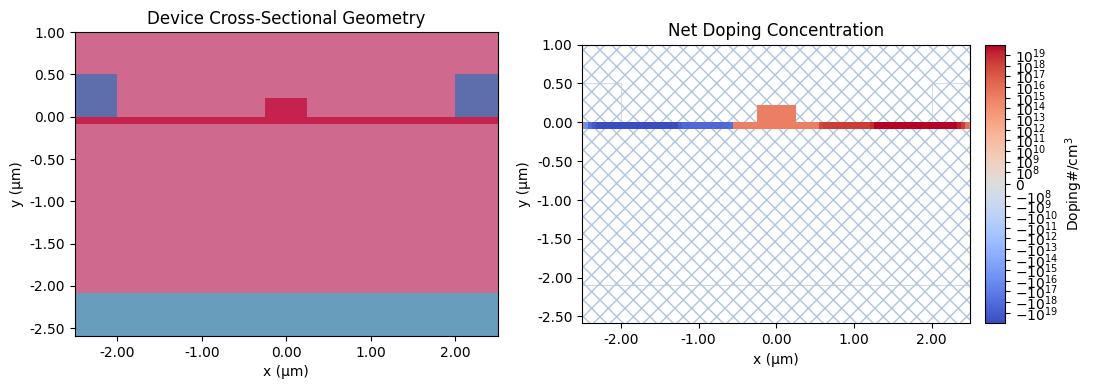

In [8]:
_, ax = plt.subplots(1, 2, figsize=(12, 5))

fig1 = scene.plot(z=0, ax=ax[0])
fig2 = scene.plot_structures_property(z=0, property="doping", ax=ax[1], scale="symlog")

ax[0].set_title("Device Cross-Sectional Geometry")
ax[1].set_title("Net Doping Concentration")

plt.show()

## Boundary Conditions
Here, we set up the electrical and thermal boundary conditions for the simulation.

* **Electrical Boundary Conditions:** A DC voltage source is applied to the anode and cathode contacts. The cathode is held at 0 V, while the anode voltage is swept to obtain the I-V characteristics.
* **Thermal Boundary Conditions:** A heat sink is defined at the bottom of the simulation domain to dissipate the heat generated by the device. For the non-isothermal simulations, a higher temperature is set at the electrodes. The temperature is artificially increased by 50 degrees to showcase different simulation results between isothermal and non-isothermal analysis.


In [9]:
# cathode
voltages_cathode = [0]
bc_p = td.HeatChargeBoundarySpec(
    condition=td.VoltageBC(source=td.DCVoltageSource(voltage=voltages_cathode)),
    placement=td.StructureStructureInterface(structures=["cathode", "pad"]),
)

voltages_anode = [0] + [0.5 + round((1 / 20) * x, 5) for x in range(17)]
# anode
bc_n = td.HeatChargeBoundarySpec(
    condition=td.VoltageBC(source=td.DCVoltageSource(voltage=voltages_anode)),
    placement=td.StructureStructureInterface(structures=["anode", "pad"]),
)
charge_bcs = [bc_n, bc_p]

# Ambient temperature for the heat sink model
temperature = 300
temperature_electrodes = 350

# cathode
bc3 = td.HeatChargeBoundarySpec(
    condition=td.TemperatureBC(temperature=temperature_electrodes),
    placement=td.StructureStructureInterface(structures=["cathode", "pad"]),
)
# anode
bc4 = td.HeatChargeBoundarySpec(
    condition=td.TemperatureBC(temperature=temperature_electrodes),
    placement=td.StructureStructureInterface(structures=["anode", "pad"]),
)

bc3a = td.HeatChargeBoundarySpec(
    condition=td.TemperatureBC(temperature=temperature_electrodes),
    placement=td.StructureStructureInterface(structures=["cathode", "soxbox"]),
)
# anode
bc4a = td.HeatChargeBoundarySpec(
    condition=td.TemperatureBC(temperature=temperature_electrodes),
    placement=td.StructureStructureInterface(structures=["anode", "soxbox"]),
)
# box
bc5 = td.HeatChargeBoundarySpec(
    condition=td.TemperatureBC(temperature=temperature),
    placement=td.StructureStructureInterface(structures=["soxbox", "contact_bottom"]),
)
thermal_bcs = [bc3, bc4, bc3a, bc4a, bc5]

## Monitors
Monitors are used to record the simulation results at different points in the simulation domain.

- `SteadyFreeCarrierMonitor`: records the steady-state free carrier concentration.
- `SteadyPotentialMonitor`: records the steady-state electric potential.
- `SteadyCapacitanceMonitor`: records the capacitance of the device.
- `TemperatureMonitor`: records the temperature distribution.

In [10]:
# monitors
charge_global_mnt = td.SteadyFreeCarrierMonitor(
    center=(0, 0, 0),
    size=(td.inf, td.inf, td.inf),
    name="charge_global_mnt",
    unstructured=True,
)

potential_global_mnt = td.SteadyPotentialMonitor(
    center=(0, 0, 0),
    size=(td.inf, td.inf, td.inf),
    name="potential_global_mnt",
    unstructured=True,
)

capacitance_global_mnt = td.SteadyCapacitanceMonitor(
    center=(0, 0, 0),
    size=(td.inf, td.inf, td.inf),
    name="capacitance_global_mnt",
    unstructured=True,
)

temp_mnt = td.TemperatureMonitor(
    center=(0, 0, 0), size=(td.inf, td.inf, td.inf), name="temp_mnt", unstructured=True
)

monitors = [charge_global_mnt, potential_global_mnt, capacitance_global_mnt, temp_mnt]
monitors_iso = [charge_global_mnt, potential_global_mnt, capacitance_global_mnt]

## Simulation Setup

Finally, we instantiate the simulation objects for each different simulation models by setting the following parameters:
- **Charge Tolerance**: `ChargeToleranceSpec` sets the convergence criteria for the charge solver.
- **Analysis Type**: `SteadyChargeDCAnalysis` specifies a steady-state direct current (DC) analysis. `IsothermalSteadyChargeDCAnalysis` allows performing the same analysis under a constant temperature.
- **Grid Specification**: `DistanceUnstructuredGrid` is used to create a non-uniform mesh for the simulation. The mesh is refined in specific regions of interest using `GridRefinementRegion` to improve accuracy where needed, such as near the junctions.

For `SteadyChargeDCAnalysis`, when `fermi_dirac=False`, the simulation uses Maxwell-Boltzmann statistics to model the distribution of charge carriers. This is a common and effective approximation for semiconductors operating under non-degenerate conditions when doping concentrations are not excessively high and temperatures are not extremely low. For the device and operating conditions modeled here, Maxwell-Boltzmann provides a sufficiently accurate and computationally efficient result. The `fermi_dirac=True` argument indicates that Fermi-Dirac statistics should be used, which is more accurate for heavily doped semiconductors.

In [11]:
charge_tolerance = td.ChargeToleranceSpec(
    rel_tol=1e-4, abs_tol=1e16, max_iters=400, ramp_up_iters=5
)
analysis_type_iso = td.IsothermalSteadyChargeDCAnalysis(
    tolerance_settings=charge_tolerance,
    convergence_dv=0.1,
    fermi_dirac=False,
    temperature=300,
)
analysis_type = td.SteadyChargeDCAnalysis(
    tolerance_settings=charge_tolerance, convergence_dv=0.1, fermi_dirac=False
)

Here we can **manually** define the regions that require a finer mesh. This is particularly useful for resolving small features or areas where fields are expected to vary rapidly, without the computational cost of making the entire grid uniformly fine. In particular, a higher refinement is applied:
- In the region where the doping concentration changes rapidly.
- In the proximity of corners (between the pad and the rib) to address singular fields.

Below, it is shown an example on how the local refined mesh might look like.

![Local_refinement](img/local_refinement.png "Local refinement visualization")

In [12]:
dl = 0.025
dl_ref = dl / 6
box_width = 0.12

# Interface between nwell and the rightmost side (not doped)
ref1 = td.GridRefinementRegion(
    center=(-2.35, -0.045, 0),
    size=(box_width, 0.1, 0),
    dl_internal=dl_ref,
    transition_thickness=dl * 20,
)

# Interface between pwell and the rightmost side (not doped)
ref2 = td.GridRefinementRegion(
    center=(2.35, -0.045, 0),
    size=(box_width, 0.1, 0),
    dl_internal=dl_ref,
    transition_thickness=dl * 20,
)

# refinement around the corner (left)
ref3 = td.GridRefinementRegion(
    center=(-0.25, -0.045, 0),
    size=(box_width, 0.1, 0),
    dl_internal=dl_ref,
    transition_thickness=dl * 20,
)

# refinement around the corner (right)
ref4 = td.GridRefinementRegion(
    center=(0.25, -0.045, 0),
    size=(box_width, 0.1, 0),
    dl_internal=dl_ref,
    transition_thickness=dl * 20,
)

# Interface between pepi and nplus
ref5 = td.GridRefinementRegion(
    center=(-1.25, -0.045, 0),
    size=(box_width, 0.1, 0),
    dl_internal=dl_ref,
    transition_thickness=dl * 20,
)

# Interface between pepi and pplus
ref6 = td.GridRefinementRegion(
    center=(1.25, -0.045, 0),
    size=(box_width, 0.1, 0),
    dl_internal=dl_ref,
    transition_thickness=dl * 20,
)

# Build a grid specification with all these custom refinements
grid_spec = td.DistanceUnstructuredGrid(
    relative_min_dl=0,
    dl_interface=dl,
    dl_bulk=20 * dl,
    distance_interface=2 * dl,
    distance_bulk=6 * dl,
    sampling=1000,
    non_refined_structures=["soxbox"],
    uniform_grid_mediums=["Si_doping"],
    mesh_refinements=[ref1, ref2, ref3, ref4, ref5, ref6],
)

In [13]:
sim_center = (0, -0.545, 0)
sim_size = (4.8, 3.5, 0)


def createSim(structures, bcs, analysis_t):
    sim = td.HeatChargeSimulation(
        medium=air,
        structures=structures,
        size=sim_size,
        center=sim_center,
        boundary_spec=bcs,
        analysis_spec=analysis_t,
        monitors=monitors,
        grid_spec=grid_spec,
    )
    return sim


sim = createSim(structures, charge_bcs + thermal_bcs, analysis_type)
sim_cst = createSim(structures_cst, charge_bcs + thermal_bcs, analysis_type)
sim_iso = createSim(structures_cst, charge_bcs, analysis_type_iso)

## Simulation visualization
Before running the simulations, we plot the heat and electric conductivities.

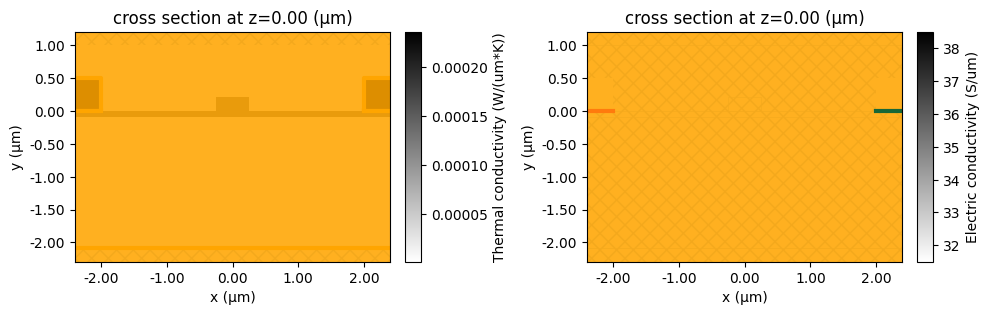

In [14]:
_, ax = plt.subplots(1, 2, figsize=(10, 4))
fig1 = sim.plot_property(z=0, property="heat_conductivity", ax=ax[0])
fig2 = sim.plot_property(z=0, property="electric_conductivity", ax=ax[1])
plt.tight_layout()

## Running the simulations

In [15]:
results_iso = web.run(sim_iso)

14:24:05 CET Created task 'heat_charge_2025-11-03_14-24-04' with resource_id    
             'hec-e8bad386-3dbd-4455-af57-83865751120a' and task_type           
             'HEAT_CHARGE'.

             Tidy3D's HeatCharge solver is currently in the beta stage. Cost of 
             HeatCharge simulations is subject to change in the future.

Output()

14:24:08 CET Estimated FlexCredit cost: 0.025. Minimum cost depends on task     
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

14:24:10 CET status = success

Output()

14:24:17 CET loading simulation from simulation_data.hdf5

In [16]:
results_cst = web.run(sim_cst)

             Created task 'heat_charge_2025-11-03_14-24-17' with resource_id    
             'hec-c52ffd53-53e3-431d-8c56-86a86f278854' and task_type           
             'HEAT_CHARGE'.

             Tidy3D's HeatCharge solver is currently in the beta stage. Cost of 
             HeatCharge simulations is subject to change in the future.

Output()

14:24:20 CET Estimated FlexCredit cost: 0.025. Minimum cost depends on task     
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

14:24:21 CET status = success

Output()

14:24:35 CET loading simulation from simulation_data.hdf5

In [17]:
results = web.run(sim)

14:24:36 CET Created task 'heat_charge_2025-11-03_14-24-35' with resource_id    
             'hec-dea842e4-b68c-47a1-9f61-f42958e6eb61' and task_type           
             'HEAT_CHARGE'.

             Tidy3D's HeatCharge solver is currently in the beta stage. Cost of 
             HeatCharge simulations is subject to change in the future.

Output()

14:24:38 CET Estimated FlexCredit cost: 0.025. Minimum cost depends on task     
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

14:24:40 CET status = success

Output()

14:24:46 CET loading simulation from simulation_data.hdf5

## Post-processing and Plotting
Once the simulations are complete, the data is post-processed to perform a comparative analysis of the different models. This analysis focuses on three key results:
- **Potential**: The electric potential distribution across the device.
- **Temperature**: The internal temperature profile.
- **IV Curve**: The device's current-voltage characteristics.

### Potential distribution

In [18]:
# Non-isothermal - Effective DOS
pot_05V = results["potential_global_mnt"].potential.sel(voltage=0.5, z=0)
pot_12V = results["potential_global_mnt"].potential.sel(voltage=1.2, z=0)
# Non-isothermal - Constant DOS
pot_05V_cst = results_cst["potential_global_mnt"].potential.sel(voltage=0.5, z=0)
pot_12V_cst = results_cst["potential_global_mnt"].potential.sel(voltage=1.2, z=0)
# Isothermal
pot_05V_iso = results_iso["potential_global_mnt"].potential.sel(voltage=0.5, z=0)
pot_12V_iso = results_iso["potential_global_mnt"].potential.sel(voltage=1.2, z=0)

#### Effective DOS

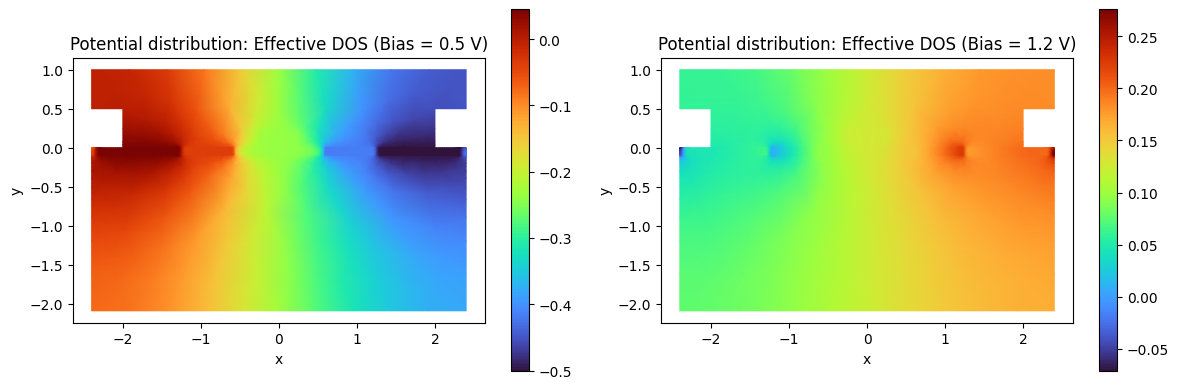

In [19]:
showGrid = False

fig, (ax) = plt.subplots(1, 2, figsize=(12, 4))

cont1 = pot_05V.plot(grid=showGrid, ax=ax[0], cmap="turbo")
cont2 = pot_12V.plot(grid=showGrid, ax=ax[1], cmap="turbo")

_ = ax[0].set_title(f"Potential distribution: Effective DOS (Bias = {0.5:.1f} V)")
_ = ax[1].set_title(f"Potential distribution: Effective DOS (Bias = {1.2:.1f} V)")

plt.tight_layout()

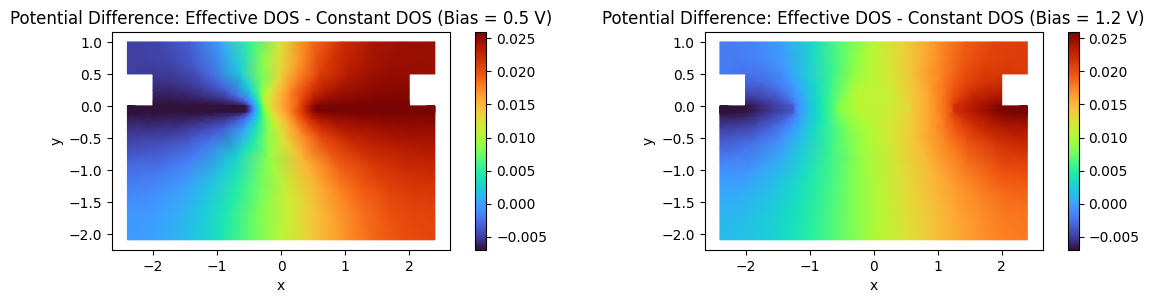

In [20]:
showGrid = False

fig, (ax) = plt.subplots(1, 2, figsize=(12, 3))

# pot = 0.0
p1 = (pot_05V - pot_05V_cst).plot(grid=showGrid, ax=ax[0], cmap="turbo")
p2 = (pot_12V - pot_12V_cst).plot(grid=showGrid, ax=ax[1], cmap="turbo")

_ = ax[0].set_title(f"Potential Difference: Effective DOS - Constant DOS (Bias = {0.5:.1f} V)")
_ = ax[1].set_title(f"Potential Difference: Effective DOS - Constant DOS (Bias = {1.2:.1f} V)")

plt.tight_layout()

These plots showcased the potential difference between the **Effective DOS** model and the **Constant DOS** model. The asymmetry arises because the intrinsic Fermi level $E_i$ shifts toward the conduction band at high temperatures. This forces an asymmetric change in band bending:
- **P-Side (right):** $E_i$ bends towards the valence band creating a positive potential difference.
- **N-Side (left):** $E_i$ bends towards the conduction band creating a negative potential difference.

#### Difference between effective DOS and isothermal potential results

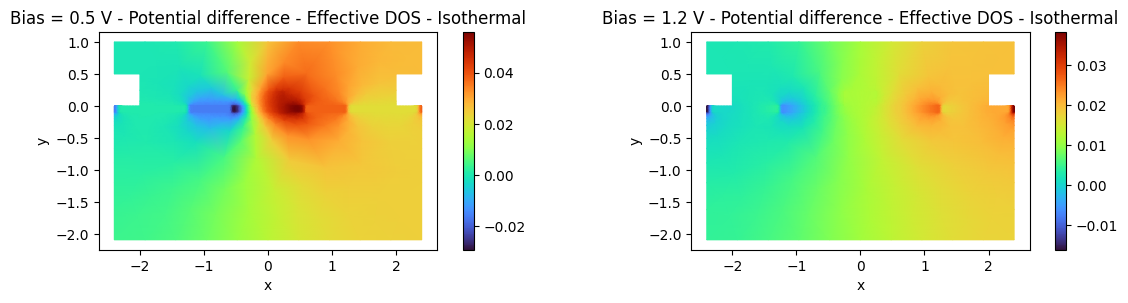

In [21]:
showGrid = False

fig, (ax) = plt.subplots(1, 2, figsize=(12, 3))

# pot = 0.0
p1 = (pot_05V - pot_05V_iso).plot(grid=showGrid, ax=ax[0], cmap="turbo")
p2 = (pot_12V - pot_12V_iso).plot(grid=showGrid, ax=ax[1], cmap="turbo")

_ = ax[0].set_title(f"Bias = {0.5:.1f} V - Potential difference - Effective DOS - Isothermal")
_ = ax[1].set_title(f"Bias = {1.2:.1f} V - Potential difference - Effective DOS - Isothermal")

plt.tight_layout()

In these plots, the potential difference between the **Effective DOS** and **Isothermal** models is even more pronounced because the latter represents a greater physical simplification. The resulting large, asymmetric difference is a direct consequence of the Isothermal model's omission of critical high-temperature effects. Specifically, it neglects the substantial increase in the intrinsic carrier concentration $n_i$ as well as the temperature-dependent shifts in the bandgap and the intrinsic Fermi level $E_i$.

### Temperature distribution

The following section presents a comparative analysis of the resulting temperature distribution between the **Effective DOS** and **Constant DOS** models. This direct comparison is intended to isolate the specific effects of temperature-dependent state densities on the device's thermal profile.

In [22]:
# Utility function to plot the function on the distribution with the same grid
def interpolate_data(x_vector, y_vector, t_vector, num_grid_points_x, num_grid_points_y):
    # Get the min/max bounds from scattered data
    xmin, xmax = x_vector.min(), x_vector.max()
    ymin, ymax = y_vector.min(), y_vector.max()

    # Create 1D arrays for the new grid coordinates
    xi = np.linspace(xmin, xmax, num_grid_points_x)
    yi = np.linspace(ymin, ymax, num_grid_points_y)

    # Create the 2D meshgrid for the interpolation output
    xi_grid, yi_grid = np.meshgrid(xi, yi)

    # The points argument to griddata should be an array of (x, y) pairs
    points = np.column_stack((x_vector, y_vector))

    # Interpolate the values onto the new grid
    ti_grid = sp.interpolate.griddata(points, t_vector, (xi_grid, yi_grid), method="linear")
    return xi_grid, yi_grid, ti_grid

In [23]:
# Define the resolution of the regular grid for interpolation
num_grid_points_x = 200
num_grid_points_y = 200

In [24]:
# Interpolating Tidy3d results - Eff. DOS
x_vector1 = results["temp_mnt"].temperature.points[:, 0].values
y_vector1 = results["temp_mnt"].temperature.points[:, 1].values
t_vector1 = results["temp_mnt"].temperature.sel(voltage=1.2).values.values[:, 0]
xi_grid1, yi_grid1, ti_grid1 = interpolate_data(
    x_vector1, y_vector1, t_vector1, num_grid_points_x, num_grid_points_y
)

# Interpolating Tidy3d results - cst
t_vector_cst = results_cst["temp_mnt"].temperature.sel(voltage=1.2).values.values[:, 0]
xi_grid1, yi_grid1, ti_grid_cst = interpolate_data(
    x_vector1, y_vector1, t_vector_cst, num_grid_points_x, num_grid_points_y
)

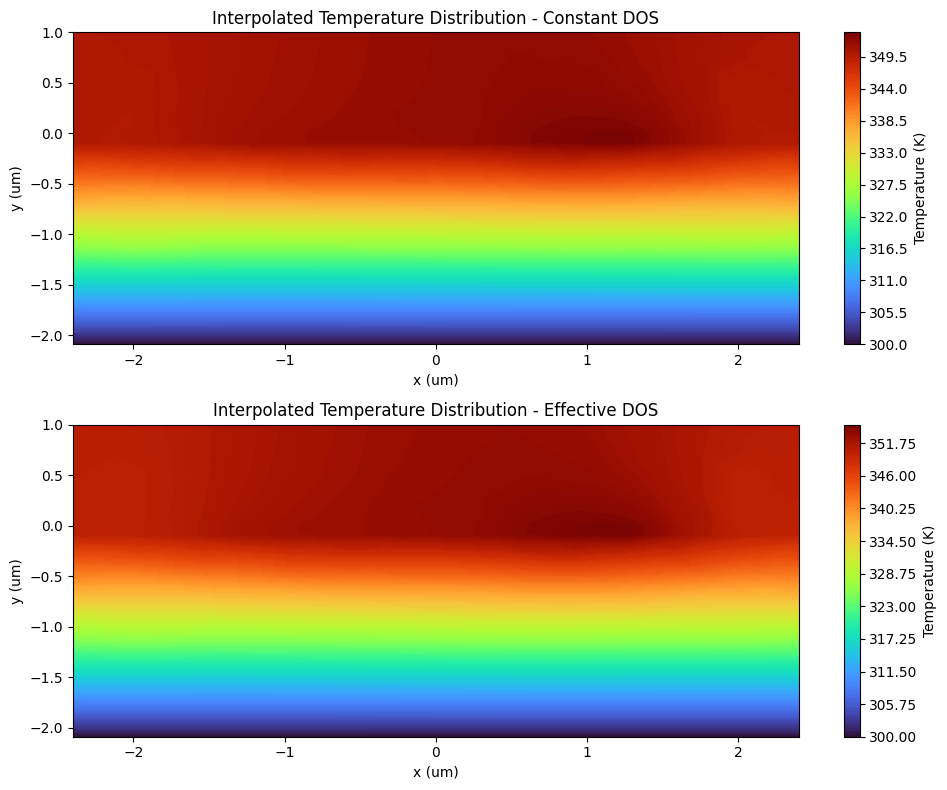

In [25]:
showGrid = False

fig, (ax) = plt.subplots(2, 1, figsize=(10, 8))

contour0 = ax[0].contourf(xi_grid1, yi_grid1, ti_grid_cst, levels=250, cmap="turbo")
ax[0].set_xlabel("x (um)")
ax[0].set_ylabel("y (um)")
ax[0].set_title("Interpolated Temperature Distribution - Constant DOS")
fig.colorbar(contour0, label="Temperature (K)", ax=ax[0])


contour1 = ax[1].contourf(xi_grid1, yi_grid1, ti_grid1, levels=250, cmap="turbo")
ax[1].set_xlabel("x (um)")
ax[1].set_ylabel("y (um)")
ax[1].set_title("Interpolated Temperature Distribution - Effective DOS")
fig.colorbar(contour1, label="Temperature (K)", ax=ax[1])


plt.tight_layout()

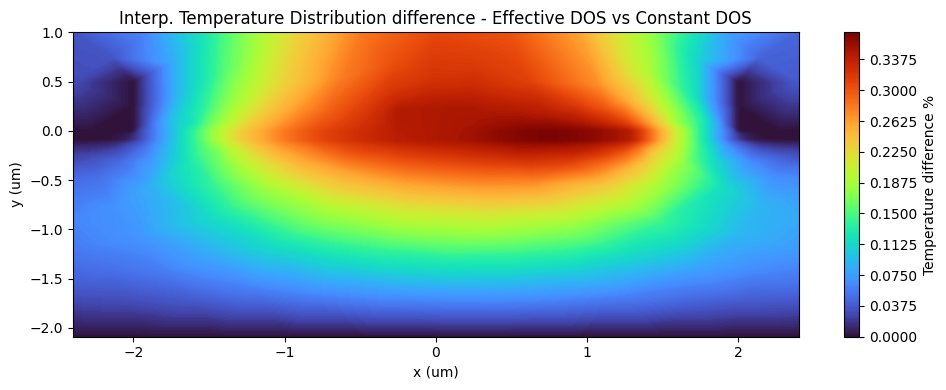

In [26]:
showGrid = False

fig, (ax) = plt.subplots(1, 1, figsize=(10, 4))

contour1 = ax.contourf(
    xi_grid1,
    yi_grid1,
    100 * np.abs((ti_grid_cst - ti_grid1) / ti_grid1),
    levels=250,
    cmap="turbo",
)
ax.set_xlabel("x (um)")
ax.set_ylabel("y (um)")
ax.set_title("Interp. Temperature Distribution difference - Effective DOS vs Constant DOS")
fig.colorbar(contour1, label="Temperature difference %", ax=ax)

plt.tight_layout()

The plots above highlight how the **Constant DOS** model underestimates the generated heat at high temperatures, as its fixed effective DOS fails to capture the temperature-driven increase in intrinsic concentration and the resulting larger currents.

### Current-Voltage (I-V) Characteristics

Finally, we plot the I-V curves obtained from the three different simulations. The goal is to highlight the impact of thermal effects and the choice of the DOS model on the device's electrical performance. We multiply the resulting currents for `norm_length` (um), which indicates the length of the device along the z direction.

In [27]:
norm_length = 500
voltage = results.device_characteristics.steady_dc_current_voltage["v"].as_numpy()
current = results.device_characteristics.steady_dc_current_voltage.values * norm_length
current_cst = results_cst.device_characteristics.steady_dc_current_voltage.values * norm_length
current_iso = results_iso.device_characteristics.steady_dc_current_voltage.values * norm_length

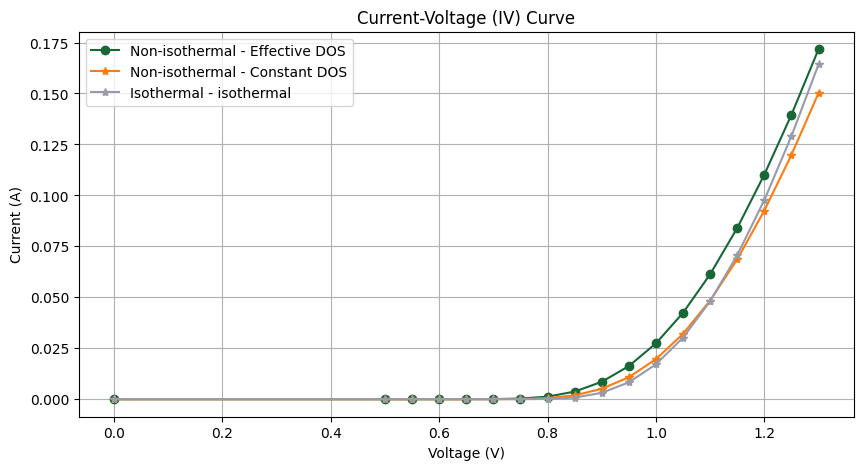

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(voltage, current, marker="o", linestyle="-")
ax.plot(voltage, current_cst, marker="*", linestyle="-")
ax.plot(voltage, current_iso, marker="*", linestyle="-")

ax.set_xlabel("Voltage (V)")
ax.set_ylabel("Current (A)")
ax.set_title("Current-Voltage (IV) Curve")
ax.legend(
    [
        "Non-isothermal - Effective DOS",
        "Non-isothermal - Constant DOS",
        "Isothermal - isothermal",
    ]
)
ax.grid(True, which="both", ls="-")
plt.show()

The results clearly show that incorporating more detailed physical models (thermal effects and temperature-dependent DOS) predicts different currents for the same applied voltage.

- **Isothermal**: This curve serves as a baseline result, as the simulation model does not account for self-heating effects.
- **Constant DOS**: The curve shows a lower current than the baseline at higher voltages. This is the expected effect of self-heating: as the device gets hotter, carrier mobility decreases, which in turn reduces conductivity and limits the current flow. However, this model still uses a simplified, constant DOS.
- **Effective DOS**: The curve predicts the highest current of the three models. This model, while accounting for the negative effects of self-heating on mobility, also correctly models the strong increase in the intrinsic carrier concentration ($n_i$) at elevated temperatures.
